In [41]:
# based on https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

import pandas as pd
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import os
import sys
import tensorflow as tf
import warnings

from generate_data import *

In [42]:
from keras.models import Sequential
from keras import layers

RNN = layers.LSTM
HIDDEN_SIZE = 40
BATCH_SIZE = 150
LAYERS = 1
NUM_STEPS = 60
NUM_LEVEL_UPDATES = 15
NUM_FEATURES = 3
NUM_ITERATIONS = 30

model = Sequential()
model.add(RNN(HIDDEN_SIZE, return_sequences=True, input_shape=(NUM_STEPS, NUM_FEATURES)))
model.add(RNN(HIDDEN_SIZE, return_sequences=True))


model.add(layers.Dense(1))
#model.add(layers.Activation('softmax'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 40)            7040      
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 40)            12960     
_________________________________________________________________
dense_3 (Dense)              (None, 60, 1)             41        
Total params: 20,041
Trainable params: 20,041
Non-trainable params: 0
_________________________________________________________________


In [43]:
# IMPORT DATA

train_df, test_df = load_data()


2018-09-20 21:41:08,741 root         DEBUG    loading entire df for river dart from sql
2018-09-20 21:41:09,418 root         DEBUG    Fill in missing timestamps by reindexing
2018-09-20 21:41:10,062 root         DEBUG    Convert cumulative rain to actual rain
2018-09-20 21:41:10,136 root         INFO     latest rain update at: 2018-08-19 21:00:00
2018-09-20 21:41:10,137 root         DEBUG    Concat rain and forecast to create model_rain
2018-09-20 21:41:10,147 root         DEBUG    interpolate model_rain


In [44]:
# CREATE SAMPLES

# x shape should be (num_samples, num_steps, num_features)
# y shape should be (num_samples, num_steps)
# Each x should be num_steps long with NUM_LEVEL_UPDATES at the start
# For each x, generate a random value and use that as the index
# Maybe later we could vary the sequence length OR include more level updates from the past


import random

raw_X = np.array(list(train_df.model_rain.values))
raw_Y = np.array(list(train_df.level.values))

x_train, y_train = create_random_samples(df = train_df, num_samples=10000, num_steps=NUM_STEPS)
x_val, y_val = create_random_samples(df = train_df, num_samples=1000, num_steps=NUM_STEPS, cutoff=0)
print y_train.shape
print x_train.shape

(10000, 60, 1)
(10000, 60, 3)


In [45]:
for iteration in range(1, NUM_ITERATIONS):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))

()
--------------------------------------------------
('Iteration', 1)
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 13s 1ms/step - loss: 0.0794 - acc: 1.8333e-05 - val_loss: 0.0204 - val_acc: 0.0000e+00
()
--------------------------------------------------
('Iteration', 2)
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 13s 1ms/step - loss: 0.0201 - acc: 4.0000e-05 - val_loss: 0.0101 - val_acc: 0.0000e+00
()
--------------------------------------------------
('Iteration', 3)
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 12s 1ms/step - loss: 0.0140 - acc: 4.0000e-05 - val_loss: 0.0088 - val_acc: 0.0000e+00
()
--------------------------------------------------
('Iteration', 4)
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 12s 1ms/step - loss: 0.0118 - a

In [46]:
# find some samples with some interesting things to look at!
for i in range(0, 1000):
    if max(y_val[i]) > 1.5:
        print i

1
31
55
136
206
215
295
393
623
799
892
942


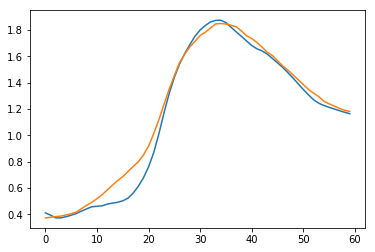

In [50]:
index = 623

plt.plot(model.predict(x_val[index:index+1,:,:]).flatten())
plt.plot(y_val[index])
plt.show()

In [73]:
from math import sqrt

prediction_errors = []
for i in range(0, 1000):
    prediction_errors.append(np.absolute(model.predict(x_val[index:index+1,:,:]).flatten() - y_val[index].flatten()))



In [84]:
print "Mean absolute error:", (sum(sum(prediction_errors)) /60000) .round(4)
print "Root mean squared error:", round(sqrt(sum(sum([pred**2 for pred in prediction_errors])) /60000), 3)

Mean absolute error: 0.0533
Root mean squared error: 0.076
